In [1]:
%load_ext autoreload
%autoreload 2

# https://www.ishares.com/us/products/239706/ishares-russell-1000-growth-etf
# https://aroussi.com/post/python-yahoo-finance
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import pandas as pd
import pickle

# Download Yahoo Data (5 minute interval)

In [2]:
import stocks as s

tix = "MSFT AAPL GOOG TSLA AMZN FB KIRK V MA UNH NFLX CRM NKE HD COST KO AMT LOW UPS ZM MMM"
# Initialize
stocks = s.DataDownloader(tix)
# Download Yahoo and transform
stocks.get_data()
stocks.transform_data()
# Write to transformed data to SQL
stocks.insert_SQL()
# Read from SQL
stocks.read_SQL('stockprice')

[*********************100%***********************]  21 of 21 completed


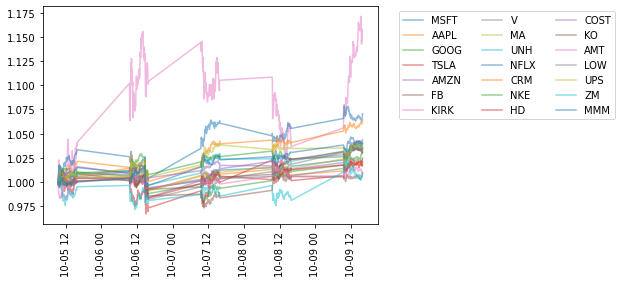

In [7]:
stocks.plot_raw(scale = 0)

# Model

In [19]:
# Pivot so each stock time series is a column
data = stocks.transformed_data.pivot_table(columns = 'symbol', index = 'DateTime')['price']
# Normalize by Last Value
data = data/data.iloc[-1]
data.to_csv("data/mydata.csv")

In [20]:
model = VAR(data)

/home/erichullander/anaconda3/envs/StockPrice/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [21]:
# 100 lags model
results = model.fit(100)
pickle.dump(results, open( "model/frozen.p", "wb" ) )
lag_order = results.k_ar
lag_order

100

# Lags and Forecasts are in 5 minute intervals

In [23]:
forecast = pd.DataFrame(results.forecast(data.values[-lag_order:], 48))
forecast.columns = data.columns
forecast.index = range(data.shape[0], data.shape[0] + forecast.shape[0])

In [52]:
all = pd.concat((data2_piv, forecast))

In [53]:
48*5

240

# Forecast next 4 hours based on last 5 days

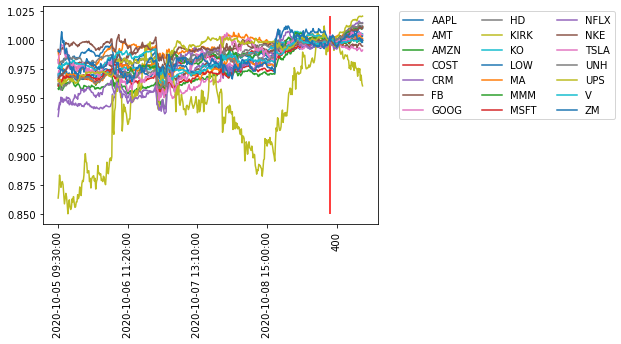

In [54]:
all.plot()
ymin = np.min(np.min(all))
ymax = np.max(np.max(all))
plt.vlines(x = data2_piv.shape[0], ymin = ymin, ymax = ymax, color = 'r')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol = int(len(stocks.split())/10) + 1)
plt.xticks(rotation=90)
plt.show()

In [7]:
stock_data.read_SQL('stockprice')

In [9]:
stock_data.transformed_data

,symbol,price
DateTime,,
2020-10-09 15:55:00,AAPL,116.970001
2020-10-06 13:20:00,AAPL,115.190002
2020-10-06 13:25:00,AAPL,115.209999
2020-10-06 13:30:00,AAPL,114.999901
2020-10-06 13:35:00,AAPL,115.000000
...,...,...
2020-10-08 12:05:00,ZM,484.179993
2020-10-08 12:10:00,ZM,483.635010
2020-10-08 12:15:00,ZM,483.059998
